# Stable Diffusion Lora Training using HuggingFace

LoRA `(Low-Rank Adaptation of Large Language Models)` is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share. LoRA can also be combined with other training techniques like DreamBooth to speedup training.

Reference: https://huggingface.co/docs/diffusers/en/training/lora

### Check that your GPU is available

In [1]:
! nvidia-smi

Wed Apr 17 12:34:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
|  0%   31C    P8             11W /  285W |     966MiB /  12282MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install Diffusers library and other requirements


In [2]:
! pip install peft xformers bitsandbytes transformers accelerate -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.0+cu121 requires torch==2.2.0+cu121, but you have torch 2.2.2 which is incompatible.
torchvision 0.17.0 requires torch==2.2.0, but you have torch 2.2.2 which is incompatible.


Make sure to install `diffusers` from `main`.

In [3]:
! pip install git+https://github.com/huggingface/diffusers.git -q

Download `diffusers` dreambooth LoRa training script.

In [4]:
! wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


## Dataset 🧑

In [5]:
DATASET_FOLDER_NAME = "fotos"  # Complete with your own dataset folder name

Preview your images:

In [6]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

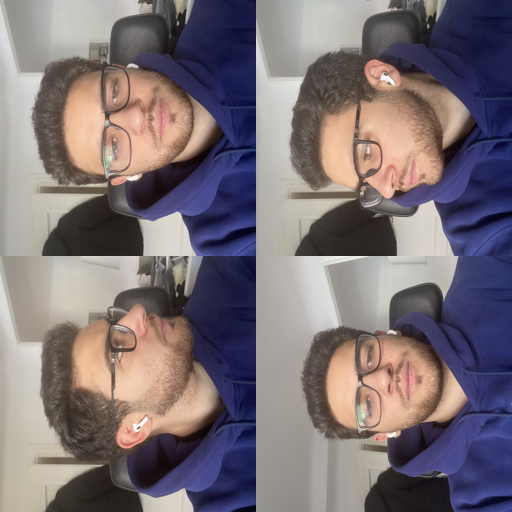

In [7]:
import glob

imgs = [Image.open(path) for path in glob.glob(f"./{DATASET_FOLDER_NAME}/*.jpg")][:10]
image_grid(imgs, 2, 2)

## Prep for training 💻

In [8]:
# To have correctly configured the versions of the different libraries in the anaconda kernel to use cuda, these are the ones I have used
! pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.2.0%2Bcu121-cp311-cp311-win_amd64.whl (2454.8 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.2.2
    Uninstalling torch-2.2.2:
      Successfully uninstalled torch-2.2.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.25.post1 requires torch==2.2.2, but you have torch 2.2.0+cu121 which is incompatible.


In [9]:
! accelerate config default

Configuration already exists at C:\Users\hugoc/.cache\huggingface\accelerate\default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


## Imports

In [10]:
from diffusers import AutoPipelineForText2Image
from diffusers import EulerAncestralDiscreteScheduler
import torch

import warnings
warnings.filterwarnings('ignore')

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\hugoc\anaconda3\Lib\site-packages\xformers\__init__.py", line 55, in _is_triton_available
    from xformers.triton.softmax import softmax as triton_softmax  # noqa
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\hugoc\anaconda3\Lib\site-packages\xformers\triton\softmax.py", line 11, in <module>
    import triton
ModuleNotFoundError: No module named 'triton'


## Training Dreambooth Lora
https://huggingface.co/docs/peft/en/task_guides/dreambooth_lora

Review all the parameters!! specially:
- `--instance_data_dir`: The directory containing the images that you intend to use for training your model.
- `--output_dir`: The destination folder for storing the trained model’s weights.
- `--pretrained_model_name_or_path`: The SD version you want to re-train
- `--learning_rate` and `--max_train_steps`: these parameter can affect the results

### Run training

If you are running this script on Windows, you may need to set the --num_dataloader_workers to 0.

In [16]:
! accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="my_dataset" \
  --output_dir="models/my_lora/" \
  --instance_prompt="a photo of sks person" \
  --resolution=512 \
  --max_train_steps=1000 \
  --checkpointing_steps=300 \
  --mixed_precision="fp16" \
  --dataloader_num_workers=0 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --lr_warmup=0 \
  --num_train_epochs=1 \
  --seed=1234 \
  --use_8bit_adam \
  --train_text_encoder

c:\Users\hugoc\anaconda3\python.exe: can't open file 'c:\\Users\\hugoc\\proyectos\\Bootcamp-IA\\Sprint 3\\Lab 3\\train_dreambooth_lora.py': [Errno 2] No such file or directory
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\hugoc\anaconda3\Scripts\accelerate.exe\__main__.py", line 7, in <module>
  File "c:\Users\hugoc\anaconda3\Lib\site-packages\accelerate\commands\accelerate_cli.py", line 46, in main
    args.func(args)
  File "c:\Users\hugoc\anaconda3\Lib\site-packages\accelerate\commands\launch.py", line 1075, in launch_command
    simple_launcher(args)
  File "c:\Users\hugoc\anaconda3\Lib\site-packages\accelerate\commands\launch.py", line 681, in simple_launcher
    raise subprocess.CalledProcessError(returncode=process.returncode, cmd=cmd)
subprocess.CalledProcessError: Command '['c:\\Users\\hugoc\\anaconda3\\python.exe', 'train_dreambooth_lora.py', '--pretrained_model_name

Once training has been completed, you can use your model for inference:

In [17]:
pipeline = AutoPipelineForText2Image.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")
pipeline.load_lora_weights("models/my_lora/", weight_name="pytorch_lora_weights.safetensors")
pipeline.scheduler=EulerAncestralDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-1.5", subfolder="scheduler")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

OSError: We couldn't connect to 'https://huggingface.co' to load this model, couldn't find it in the cached files and it looks like models/my_lora/ is not the path to a directory containing a file named pytorch_lora_weights.safetensors or 
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/diffusers/installation#offline-mode'.

  0%|          | 0/50 [00:00<?, ?it/s]

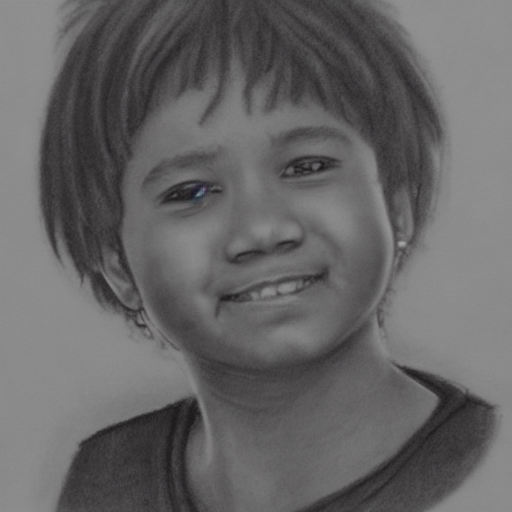

In [13]:
image = pipeline("A pencil portrait of sks").images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

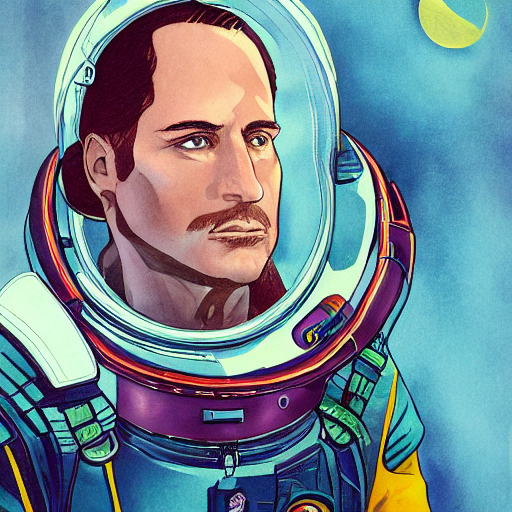

In [14]:
image = pipeline("A portrait of sks as space adventurer, very detailed, by greg rutkowsky", guidance_scale=7, num_inference_steps=50).images[0]
image

### With Prior Preservation

This technique helps the model by giving it more context as to what the new concept is. For example, if you are training with a person's face, it helps to accompany your photos with images of what the model understands to be a "person"

To do that, download all "person" images from https://github.com/aitrepreneur/REGULARIZATION-IMAGES-SD

In [18]:
! git clone https://github.com/aitrepreneur/REGULARIZATION-IMAGES-SD.git

Cloning into 'REGULARIZATION-IMAGES-SD'...
error: unable to write file C:/Users/hugoc/proyectos/Bootcamp-IA/Sprint 3/Lab 3/REGULARIZATION-IMAGES-SD/.git/objects/pack/pack-905d06172cc113790b68f334fb294fbc31fdd732.rev: No such file or directory
fatal: unable to rename temporary '*.rev' file to 'C:/Users/hugoc/proyectos/Bootcamp-IA/Sprint 3/Lab 3/REGULARIZATION-IMAGES-SD/.git/objects/pack/pack-905d06172cc113790b68f334fb294fbc31fdd732.rev'
fatal: fetch-pack: invalid index-pack output


Then, we can add the parameters:
```--with_prior_preservation \
  --num_class_images=50 \
  --class_data_dir="REGULARIZATION-IMAGES-SD/person" \
  --class_prompt="photo of a person"
```

Please note that if you do not use these downloaded images and run the code, the algorithm will generate "person" images automatically. But it usually works better just with these that the user `aitrepreneu` adjusted for you.

In [19]:
! accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="my_dataset" \
  --output_dir="models/my_lora_prior/" \
  --instance_prompt="a photo of sks person" \
  --resolution=512 \
  --max_train_steps=300 \
  --checkpointing_steps=300 \
  --mixed_precision="fp16" \
  --dataloader_num_workers=0 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --lr_warmup=0 \
  --num_train_epochs=1 \
  --seed=1234 \
  --prior_loss_weight=1.0 \
  --use_8bit_adam \
  --train_text_encoder \
  --with_prior_preservation \
  --num_class_images=50 \
  --class_data_dir="REGULARIZATION-IMAGES-SD/person" \
  --class_prompt="photo of a person"

c:\Users\hugoc\anaconda3\python.exe: can't open file 'c:\\Users\\hugoc\\proyectos\\Bootcamp-IA\\Sprint 3\\Lab 3\\train_dreambooth_lora.py': [Errno 2] No such file or directory
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\hugoc\anaconda3\Scripts\accelerate.exe\__main__.py", line 7, in <module>
  File "c:\Users\hugoc\anaconda3\Lib\site-packages\accelerate\commands\accelerate_cli.py", line 46, in main
    args.func(args)
  File "c:\Users\hugoc\anaconda3\Lib\site-packages\accelerate\commands\launch.py", line 1075, in launch_command
    simple_launcher(args)
  File "c:\Users\hugoc\anaconda3\Lib\site-packages\accelerate\commands\launch.py", line 681, in simple_launcher
    raise subprocess.CalledProcessError(returncode=process.returncode, cmd=cmd)
subprocess.CalledProcessError: Command '['c:\\Users\\hugoc\\anaconda3\\python.exe', 'train_dreambooth_lora.py', '--pretrained_model_name

Once training has been completed, you can use your model for inference:

In [20]:
pipeline = AutoPipelineForText2Image.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")
pipeline.load_lora_weights("models/my_lora_prior", weight_name="pytorch_lora_weights.safetensors")
pipeline.scheduler=EulerAncestralDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-1.5", subfolder="scheduler")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

OSError: models/my_lora_prior is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `token` or log in with `huggingface-cli login`.

  0%|          | 0/50 [00:00<?, ?it/s]

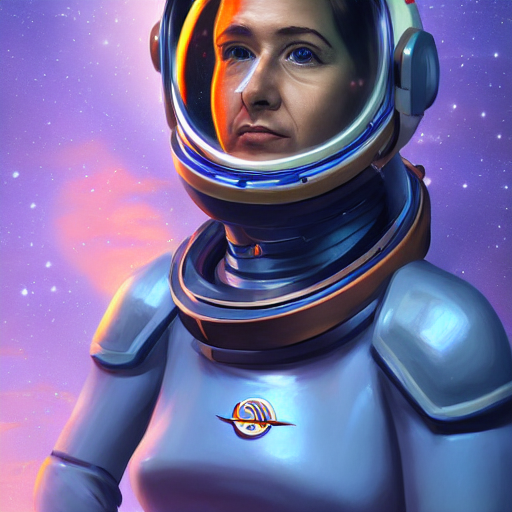

In [21]:
image = pipeline("A portrait of sks as space adventurer, very detailed, by greg rutkowsky, trending on artstation, sci-fi background", guidance_scale=9, num_inference_steps=50).images[0]
image

More training!

In [22]:
# # 1.000 steps, 100 class images

! accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="my_dataset" \
  --output_dir="models/my_lora_prior_1000steps/" \
  --instance_prompt="a photo of sks person" \
  --resolution=512 \
  --max_train_steps=1000 \
  --checkpointing_steps=1000 \
  --mixed_precision="fp16" \
  --dataloader_num_workers=8 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --lr_warmup=0 \
  --num_train_epochs=1 \
  --seed=1234 \
  --prior_loss_weight=1.0 \
  --use_8bit_adam \
  --train_text_encoder \
  --with_prior_preservation \
  --num_class_images=100 \
  --class_data_dir="REGULARIZATION-IMAGES-SD/person" \
  --class_prompt="photo of a person"

c:\Users\hugoc\anaconda3\python.exe: can't open file 'c:\\Users\\hugoc\\proyectos\\Bootcamp-IA\\Sprint 3\\Lab 3\\train_dreambooth_lora.py': [Errno 2] No such file or directory
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\hugoc\anaconda3\Scripts\accelerate.exe\__main__.py", line 7, in <module>
  File "c:\Users\hugoc\anaconda3\Lib\site-packages\accelerate\commands\accelerate_cli.py", line 46, in main
    args.func(args)
  File "c:\Users\hugoc\anaconda3\Lib\site-packages\accelerate\commands\launch.py", line 1075, in launch_command
    simple_launcher(args)
  File "c:\Users\hugoc\anaconda3\Lib\site-packages\accelerate\commands\launch.py", line 681, in simple_launcher
    raise subprocess.CalledProcessError(returncode=process.returncode, cmd=cmd)
subprocess.CalledProcessError: Command '['c:\\Users\\hugoc\\anaconda3\\python.exe', 'train_dreambooth_lora.py', '--pretrained_model_name

In [23]:
pipeline = AutoPipelineForText2Image.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")
pipeline.load_lora_weights("models/my_lora_prior_1000steps/", weight_name="pytorch_lora_weights.safetensors")
pipeline.scheduler=EulerAncestralDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-1.5", subfolder="scheduler")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

OSError: We couldn't connect to 'https://huggingface.co' to load this model, couldn't find it in the cached files and it looks like models/my_lora_prior_1000steps/ is not the path to a directory containing a file named pytorch_lora_weights.safetensors or 
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/diffusers/installation#offline-mode'.

  0%|          | 0/50 [00:00<?, ?it/s]

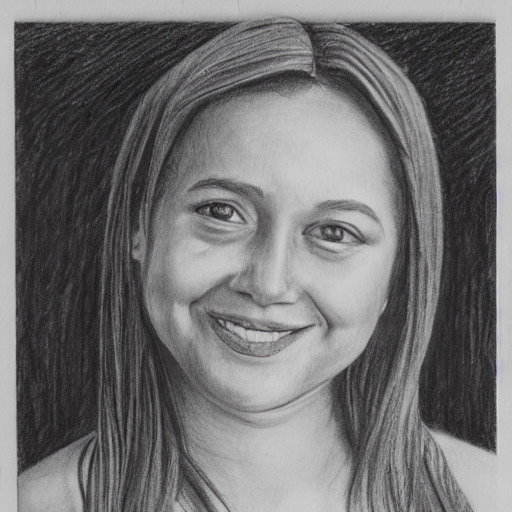

In [24]:
image = pipeline("A pencil portrait of sks person").images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

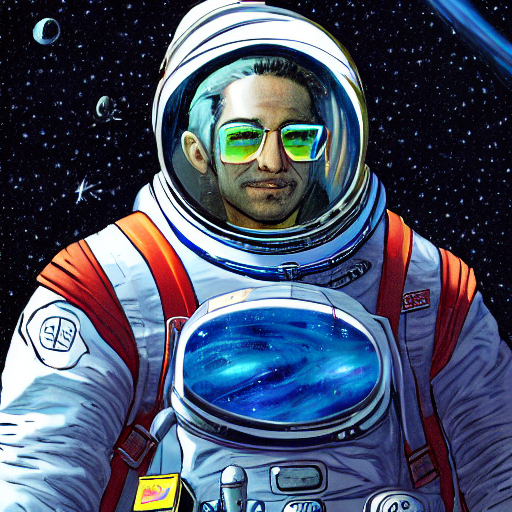

In [25]:
image = pipeline("A portrait of sks as space adventurer, very detailed, by greg rutkowsky", guidance_scale=7, num_inference_steps=50).images[0]
image

---

`Exercise`: Try to find out which **scheduler** works best as you have learned in the previous lab.

`Exercise`: Investigate how to train your model using different techniques.

---

# Training SDXL with Dreambooth and LoRA

In the Huggingface diffusers library repository you can find other ways to train the models.

For example, this is the script to train the SDXL model:


In [26]:
! wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


**Note:**
The first thing this code does is download the +10GB model. Then a looooooong training session will begin that can last a long time (+1 hour)... be patient! :)

In [27]:
! accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --instance_data_dir="my_dataset" \
  --output_dir="my_lora_xl_model" \
  --mixed_precision="fp16" \
  --instance_prompt="a photo of sks person" \
  --resolution=1024 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=2 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed=1234

# --enable_xformers_memory_efficient_attention \

c:\Users\hugoc\anaconda3\python.exe: can't open file 'c:\\Users\\hugoc\\proyectos\\Bootcamp-IA\\Sprint 3\\Lab 3\\train_dreambooth_lora_sdxl.py': [Errno 2] No such file or directory
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\hugoc\anaconda3\Scripts\accelerate.exe\__main__.py", line 7, in <module>
  File "c:\Users\hugoc\anaconda3\Lib\site-packages\accelerate\commands\accelerate_cli.py", line 46, in main
    args.func(args)
  File "c:\Users\hugoc\anaconda3\Lib\site-packages\accelerate\commands\launch.py", line 1075, in launch_command
    simple_launcher(args)
  File "c:\Users\hugoc\anaconda3\Lib\site-packages\accelerate\commands\launch.py", line 681, in simple_launcher
    raise subprocess.CalledProcessError(returncode=process.returncode, cmd=cmd)
subprocess.CalledProcessError: Command '['c:\\Users\\hugoc\\anaconda3\\python.exe', 'train_dreambooth_lora_sdxl.py', '--pretrained_

Prepare Inference Pipeline

In [28]:
from diffusers import DiffusionPipeline
import torch

from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae, torch_dtype=torch.float16, variant="fp16",
    use_safetensors=True
).to("cuda")

pipe.load_lora_weights("my_lora_xl_model")

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

(…)diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

RepositoryNotFoundError: 401 Client Error. (Request ID: Root=1-661fa880-195b1c805f8207b004e93dc2;d0b2c39b-d10c-46ec-8d13-58393dad525d)

Repository Not Found for url: https://huggingface.co/api/models/my_lora_xl_model.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.
Invalid username or password.

Add scheduler

In [ ]:
pipe.scheduler=EulerAncestralDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="scheduler")

Execute it!

In [ ]:
image = pipe("A portrait of sks as space adventurer, very detailed, ultradefined", guidance_scale=7.5, num_inference_steps=50).images[0]
image

---

#### Training Dreambooth but not using LoRA. Train all the weights of the StableDiffusion model

¡There are even other ways to train the model! For example, this is the way to "pure dreambooth training", that is, training all the weights of the Stable Diffusion model.

In [ ]:
! wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth.py

---